In [1]:
import sys; sys.path.append("..")
import torch
import matplotlib.pyplot as plt
from model import Dataset, ELM1D

dt = .05
L = 200 
D_all = next(iter(Dataset('ks1d_inhomogeneous.npy')))

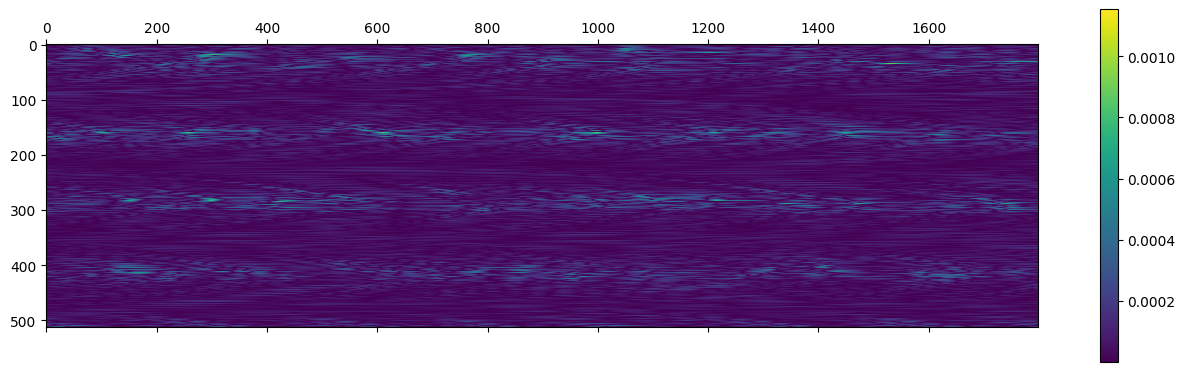

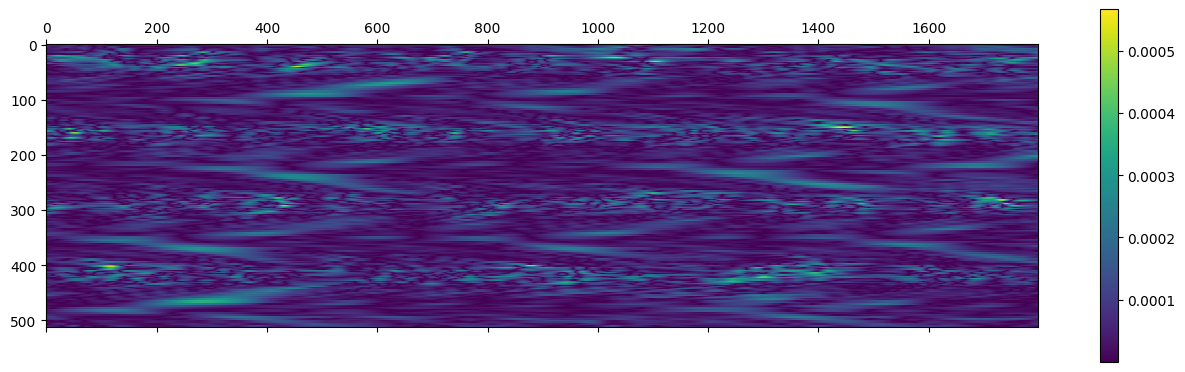

In [2]:
D_train = D_all[:201,...]
D_test = D_all[201:,...]

maxval, minval = D_train.max(), D_train.min()
normalize = lambda x: (x-minval)/(maxval-minval)
denormalize = lambda x: x*(maxval-minval)+minval

D_train = normalize(D_train)
D_test = normalize(D_test)

model_hom = ELM1D(7, 4, 150, 0)
model_inhom = ELM1D(7, 4, 150, 3)
model_hom.train([D_train], stopping_threshold=1e-4, noise=1e-4)
model_inhom.train([D_train], stopping_threshold=1e-4, noise=1e-4)

I = torch.randint(D_test.shape[0]-1,(1000,))
X_test = D_test[:-1,...]
Y_test = D_test[1:,...]

plt.colorbar(plt.matshow((model_inhom(X_test).detach()-Y_test).abs().T.numpy()))
plt.show()
plt.colorbar(plt.matshow((model_hom(X_test).detach()-Y_test).abs().T.numpy()))
plt.show()

In [3]:
M, N = D_test.shape
V_preds = []
V_errors = []

for k, model in enumerate([model_inhom, model_hom]):
    V_pred = torch.empty(M, N, dtype=torch.float64)
    V_pred[0,:] = D_test[0,:]
    for i in range(M-1): V_pred[i+1,:] = model(V_pred[i,None,:]).detach()
    V_pred = denormalize(V_pred)
    V_preds.append(V_pred)
    V_errors.append((V_pred-denormalize(D_test)).abs())

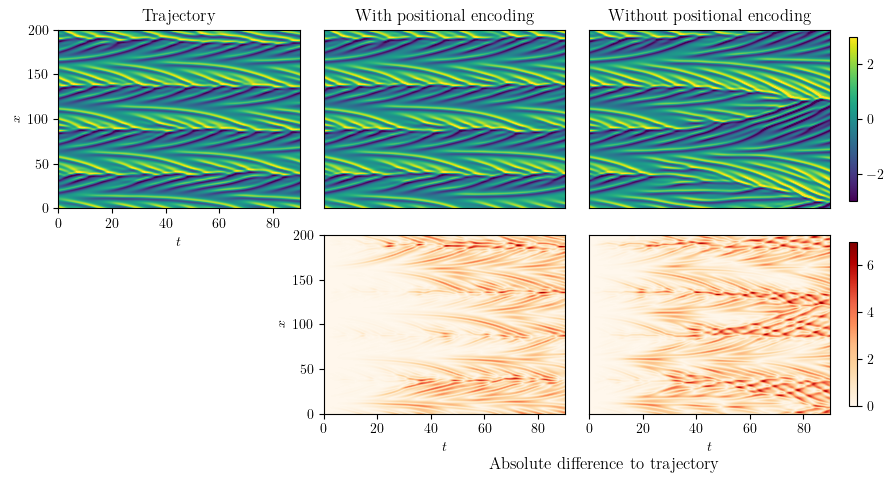

In [4]:
M, N = D_test.shape

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    'text.latex.preamble': r'\usepackage{amsfonts,bm}'
})

fig = plt.figure(figsize=(12,8))
(ax_top, ax_btm) = fig.subplots(2,3,gridspec_kw={"hspace":-.5, "wspace": .1})

asp = 1/3
ext = [0,M*dt,0,L]

for k, model in enumerate([model_inhom, model_hom]):
    im1 = ax_top[k+1].imshow(V_preds[k].numpy().T, vmax=3, vmin=-3, aspect=asp, extent=ext)
    im2 = ax_btm[k+1].imshow(V_errors[k].numpy().T, aspect=asp, cmap="OrRd", extent=ext)
    
ax_top[1].set_title("With positional encoding")
ax_top[2].set_title("Without positional encoding")
ax_btm[1].set_xlabel("$t$")
ax_btm[2].set_xlabel("$t$")
ax_top[0].set_ylabel("$x$")
ax_btm[1].set_ylabel("$x$")
ax_top[1].set_yticks([])
ax_top[2].set_yticks([])
ax_btm[2].set_yticks([])
ax_top[1].set_xticks([])
ax_top[2].set_xticks([])
fig.colorbar(im1, ax=ax_top, shrink=0.4, pad=0.02)
fig.colorbar(im2, ax=ax_btm, shrink=0.4, pad=0.02)

ax_btm[1].text(105, -50, "Absolute difference to trajectory", ha="center", va="top", rotation="horizontal", fontsize="large")
ax_btm[0].remove()
ax_top[0].set_title("Trajectory")
ax_top[0].set_xlabel("$t$")
img = denormalize(D_test)
im0 = ax_top[0].imshow(img.T.numpy(), vmax=3, vmin=-3, aspect=asp, extent=ext)

plt.savefig("plots/ks1d_inhomogeneous.pdf", format="pdf", bbox_inches="tight")
plt.show()


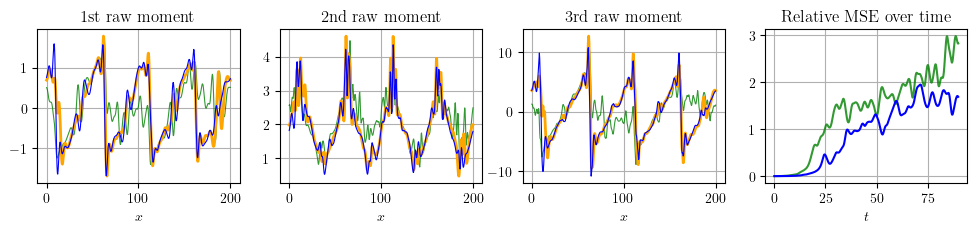

In [40]:
x = torch.linspace(0,L,N)
t = torch.linspace(0,dt*M,M)

fig, ax = plt.subplots(1,4,figsize=(12,2))
ax[0].set_title(f"1st raw moment")
ax[1].set_title(f"2nd raw moment")
ax[2].set_title(f"3rd raw moment")
for k in range(3):
    ax[k].plot(x, V_preds[1].pow(k+1).mean(dim=0),linewidth=0.8,alpha=0.8,color="green")
    ax[k].plot(x, denormalize(D_test).pow(k+1).mean(dim=0),linewidth=2,color="orange")
    ax[k].plot(x, V_preds[0].pow(k+1).mean(dim=0),linewidth=0.8,color="blue")
    ax[k].set_xlabel("$x$")
    ax[k].grid()
err0 = (V_preds[0]-denormalize(D_test)).pow(2).mean(dim=1)
err0 = err0/denormalize(D_test).pow(2).mean(dim=1)
err1 = (V_preds[1]-denormalize(D_test)).pow(2).mean(dim=1)
err1 = err1/denormalize(D_test).pow(2).mean(dim=1)
ax[3].plot(t, err1,alpha=0.8,color="green")
ax[3].plot(t, err0,color="blue")
ax[3].set_title("Relative MSE over time")
ax[3].set_xlabel("$t$")
ax[3].grid()
plt.savefig("plots/statistics.pdf", format="pdf", bbox_inches="tight")
plt.show()